In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount( '/content/drive', force_remount=True)

Mounted at /content/drive


# $ \color{red}{ \textit{ Create Data: } } $

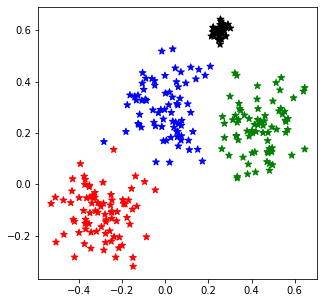

In [3]:
import random

ys = [ -0.1, 0.2, 0.3, 0.6 ]
xs = [ -0.3, 0.45, 0, 0.25 ]
rs = [ 0.25, 0.25, 0.25, 0.05 ] 
ns = [ 80, 75, 75, 40 ]

cols = [ 'red', 'green', 'blue', 'black' ]

cx = []
cy = []
cc = []
ci = []
for n in range( len(ys) ):
    for _ in range( ns[n] ):
        cx.append( 0.4 * rs[n] * np.random.randn(1)[0] + xs[n] )
        cy.append( 0.4 * rs[n] * np.random.randn(1)[0] + ys[n] )
        cc.append( cols[n] )
        ci.append( n )



plt.figure( figsize=(5,5) ) 
plt.scatter( cx, cy, s=50, c=cc , marker = '*')
plt.show()

In [4]:
cloud = []

for n in range( len(cx) ):
    cloud.append( [ cx[n], cy[n], ci[n]] )

In [5]:
# np.save( '/content/drive/MyDrive/Classifier/cloud_data_1.npy', cloud )
# print( int(np.load( '/content/drive/MyDrive/Classifier/cloud_data_1.npy' )[190,2]) )

# $ \color{red}{ \textit{ Classify Data: } } $

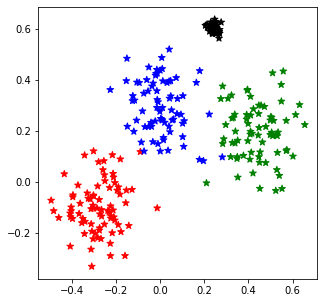

In [6]:
data = np.load( '/content/drive/MyDrive/Classifier/cloud_data_1.npy' )

cols = [ 'red', 'green', 'blue', 'black' ]

X = [ x for x in data[:,0] ]
Y = [ y for y in data[:,1] ]
C = [ cols[int( n )] for n in data[:,2] ]



plt.figure( figsize = (5,5) )
plt.scatter( X, Y, c = C, s=50, marker = '*' )
plt.show()

In [158]:
def score_classif( K, classif_exp, classif_true):
    score = 0
    count = 0

    for i in range( len(classif_true) ):
        if classif_exp[i] == classif_true[i]:
            score += 1
        count += 1

    return score/count



def compute_inertia(K, seeds, data, classif_exp):
    # Variations
    G = np.mean( seeds , axis=1 )
    N = data.shape[0]

    # Inter classes
    ni = np.zeros(K)
    I_inter = 0
    for k in range(K):
        for n in range( len(classif_exp) ):
            if classif_exp[n] == k:
                ni[k] += 1
        # ni = sum( classif_exp == j )
        I_inter = I_inter + ni[k] * sum( (seeds[:,k] - G)**2 )
    I_inter = I_inter/N


    # Intra classes
    I_intra = 0
    for j in range(N):
        I_intra = I_intra + sum( (seeds[:,int(classif_exp[j])] - data[j,0:2])**2 )

    I_intra = I_intra/N

    # Totale
    I_tot = 0
    for j in range(N):
        I_tot = I_tot + sum( (G - data[j,0:2])**2 )

    I_tot = I_tot/N

    return I_inter, I_intra, I_tot


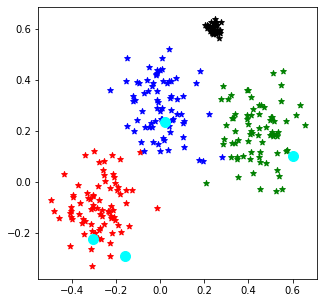

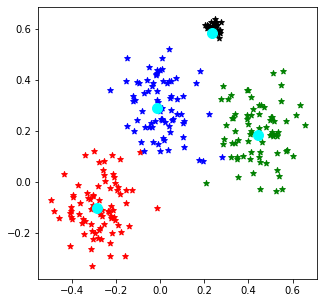

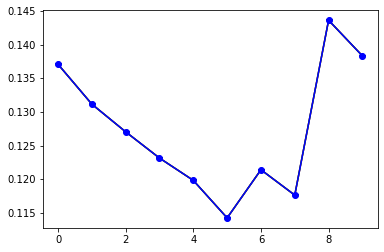

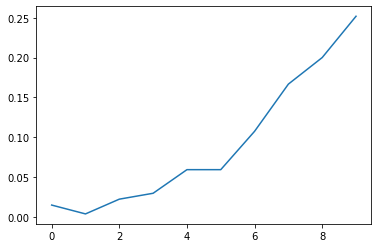

In [165]:
from math import ceil

N, _ = data.shape

classif_true = np.array( [ int(n) for n in data[:,2]] )
K = len( list(set( classif_true)))
X = data[:,0:2]

colors = [ 'red', 'green', 'blue', 'black', 'yellow', 'orange', 'purple' ]


plt.figure( figsize=(5,5) )
for n in range( N ):
    plt.scatter( data[n,0], data[n,1], c=colors[classif_true[n]], marker='*')



###########################################
### INITIALISATION ###
###########################################
iter = 10

Gi = np.zeros( (2,K) )

init = 2      # 0 = random, 1 = ginput, 2 = kmeans++
use_medo = 1  # 0 = barycentre, 1 = point central




if init == 0:
        Gi[0,:] = np.random.rand(1,K) * ( max(X[:,0])-min(X[:,0]) ) + min(X[:,0])
        Gi[1,:] = np.random.rand(1,K) * ( max(X[:,1])-min(X[:,1]) ) + min(X[:,1])

elif init == 1:
        [x,y] = plt.ginput( n=K )
        Gi[0,:] = y
        Gi[1,:] = x

elif init == 2:
        # Sélection d'un échantillon aléatoire
        Gi[:,0] = X[ ceil(np.random.rand(1)*N), :]
        # Distances D^2(x) des données X au premier Gi
        D2 = np.sum( (X - Gi[:,0])**2, axis=1 )

        for i in range(1,K):
            # Somme cumulée H(L)
            H = np.cumsum(D2)
            # Normalisation
            H = H/H[len(H)-1]
            # Tirage aléatoire d'un nouveau Gi
            vals = H > np.random.rand(1)
            for q in range(len(vals)):
                if vals[q]:
                    Gi[:,i] = X[ q, : ]
                    break
            # Distance de chaque point X à tous les barycentres

            Dk = np.zeros( (N, i) )
            for j in range(i):
                Dk[:,j] = np.sum( (X - Gi[:,j])**2, axis=1 )
  
            # Sélection de la plus petite distance
            for n in range( N ):
                D2[n] = min( Dk[n,:] )


plt.scatter( Gi[0,:], Gi[1,:], c = 'cyan', s=100 )
plt.show()




## K means loop

I_inter = np.zeros( iter ) 
I_intra = np.zeros( iter ) 
I_tot = np.zeros( iter ) 
scores = np.zeros( iter ) 

classif_exp = np.zeros( N ).astype( 'int64' )    #  Vecteur de classif

dist = np.zeros( (N,K) )

for i in range(iter): 
    #  Compute closest association
    for n in range(K):
        dist[:,n] = sum( np.transpose( (X - Gi[:,n])**2) ) 

    for n in range( len( dist ) ):
        classif_exp[n] = np.argmin( dist[n,:] ) 



    # Update barycenters
    if use_medo == 0:
        # Classic average
        for k in range(K):
            Xk = []
            for n in range(N): 
                if classif_exp[n] == k:
                    Xk.append( X[n] )
            Xk = np.array( Xk )
            
            Gi[:,k] = np.mean( Xk, axis = 0 )

    elif use_medo == 1:
        # Medoids
        for k in range( K):
            Xk = []
            for n in range(N): 
                if classif_exp[n] == k:
                    Xk.append( X[n] )
            Xk = np.array( Xk )
            dist_k = np.zeros( len(Xk) )
            for kk in range(len(Xk)):
                dist_k[kk] = sum(sum( np.transpose( (Xk - Xk[kk,:])**2)))

            p = np.argmin( dist_k)
            Gi[:,k] = Xk[p,:]


    # Score classif
    scores[i] = score_classif(K, classif_exp, classif_true)
   
   
    # Inertia
    I_inter_i, I_intra_i, I_tot_i = compute_inertia(K, Gi, data, classif_exp)
    I_inter[i] = I_inter_i 
    I_intra[i] = I_intra_i
    I_tot[i] = I_tot_i
   



plt.figure( figsize=(5,5) )
for n in range( N ):
    plt.scatter( data[n,0], data[n,1], c=colors[classif_true[n]], marker='*')
plt.scatter( Gi[0,:], Gi[1,:], c = 'cyan', s=100 )
plt.show()


plt.figure()
plt.plot( I_inter, c='r' )
plt.plot( I_inter, c='g', marker = '*' )
plt.plot( I_inter, c='b', marker = 'o' )
plt.show()

plt.figure()
plt.plot( scores )
plt.show()
